In [3]:
#%env CUDA_VISIBLE_DEVICES ""      # Rendering on CPU is approx. 10x slower
%env CUDA_VISIBLE_DEVICES 0

from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
import torch
from utils.load_blender import pose_spherical, pose_spherical2
import run_dnerf
from run_dnerf import render_path, device
from run_dnerf_helpers import to8b

env: CUDA_VISIBLE_DEVICES=0


In [49]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')           # Use this when on GPU

# get config file
config_file = "configs/johannes.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
# hwff = [480, 360, 398.907, 398.907]
hwff = [480, 640, 398.907, 398.907]
# hwf = [480, 640, 574]
# hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 0.1, 'far' : 2.1})
# render_kwargs_test.update({'near' : 2., 'far' : 6.})

[Config] NeRF type selected: direct_temporal
[Info] Found ckpts:
		./logs/report_johannes_05_mse_dgs/100000.tar
		./logs/report_johannes_05_mse_dgs/200000.tar
		./logs/report_johannes_05_mse_dgs/300000.tar
		./logs/report_johannes_05_mse_dgs/400000.tar
[Info] Reloading from ./logs/report_johannes_05_mse_dgs/400000.tar


## Generate Frame

In [50]:
def generate_img(time, azimuth, elevation, depth):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    # render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, 4.0), 0).to(device)
    render_poses = torch.unsqueeze(pose_spherical2(azimuth, elevation, depth), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, disps, depths = render_path(render_poses, render_times, hwff, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

100%|██████████| 1/1 [00:36<00:00, 36.88s/it]


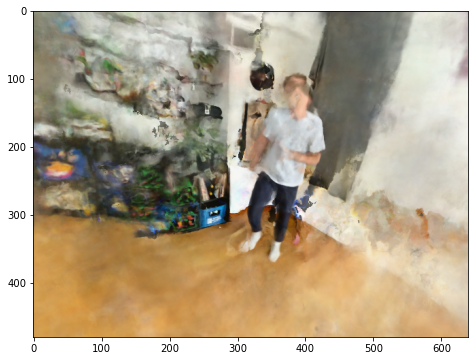

In [51]:
# genearte
time = 0.55  # in [0,1]
azimuth = -50  # in [-90,0]      
elevation = -25  # in [-45,45]
SCENE_OBJECT_DEPTH = 1.6
img = generate_img(time, azimuth, elevation, depth=SCENE_OBJECT_DEPTH)

# display
plt.figure(2, figsize=(20,6))
plt.imshow(img)
plt.show()